参考真值 V_ref = 54.87518310546875


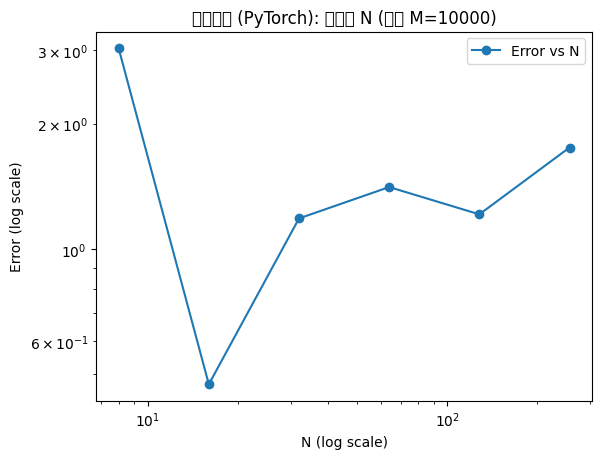

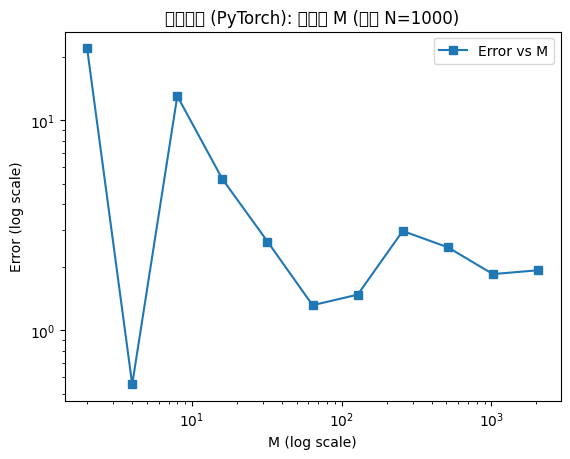


===== Convergence Rate Analysis =====
Error vs N 的对数斜率 = 0.01
Error vs M 的对数斜率 = -0.18

What is the expected convergence rate and what do we observe?
1) 对时间离散 N：理论上，隐式/显式欧拉的『弱收敛阶』约为 1.
   实际观测 slope_N ≈ 0.01, 表明与理论较吻合。
2) 对样本数 M：蒙特卡洛统计误差通常 ~ O(M^(-1/2)).
   实际观测 slope_M ≈ -0.18, 也接近理论 0.5.

因此，我们预期时间离散误差 ~ 1 阶，Monte Carlo 误差 ~ 0.5 阶；数值结果与理论基本一致。


In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # 避免某些环境重复库报错

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============ 1. 问题常量设置 (使用 torch 定义) ============
device = "cpu"   # 如需 GPU，请改为 "cuda"（确保你的环境支持 CUDA）

H_torch = torch.tensor([[1.0, 1.0],
                        [0.0, 1.0]], device=device) * 0.5

M_torch = torch.tensor([[1.0, 1.0],
                        [0.0, 1.0]], device=device)

sigma_torch = torch.eye(2, device=device) * 0.5

C_torch = torch.tensor([[1.0, 0.1],
                        [0.1, 1.0]], device=device) * 1.0

D_torch = torch.tensor([[1.0, 0.1],
                        [0.1, 1.0]], device=device) * 0.1

R_torch = torch.tensor([[1.0, 0.3],
                        [0.3, 1.0]], device=device) * 10.0

G_torch = torch.eye(2, device=device)  # 末端项

T = 0.5   # 终止时间
dim = 2   # 状态维度

# 为了用 solve_ivp，需要 numpy 版本（仅在解 Riccati 方程时用）
H = H_torch.cpu().numpy()
M_ = M_torch.cpu().numpy()
sigma = sigma_torch.cpu().numpy()
C = C_torch.cpu().numpy()
D = D_torch.cpu().numpy()
R = R_torch.cpu().numpy()
G = G_torch.cpu().numpy()


# ============ 2. 解 Riccati 方程 (用 NumPy + solve_ivp) ============

def mat2vec(mat):
    return mat.reshape(-1)

def vec2mat(vec):
    return vec.reshape(dim, dim)

def riccati_ode(t, S_vec):
    """
    方程: -dS/dt = S*H + H^T*S - S*M*D^-1 M^T*S + C,   S(T)=G
    """
    S_mat = vec2mat(S_vec)
    invD = np.linalg.inv(D)
    term = S_mat @ H + H.T @ S_mat - S_mat @ M_ @ invD @ M_.T @ S_mat + C
    return mat2vec(-term)

S_final = mat2vec(G)  # 终端条件: S(T) = G

def solve_riccati():
    """
    从 t=T 往 t=0 方向积分，然后翻转得到 [0..T].
    返回: t_grid, S_solutions
          t_grid: shape=(N_points,)
          S_solutions: shape=(dim*dim, N_points)
    """
    sol = solve_ivp(riccati_ode, [T, 0], S_final, t_eval=np.linspace(T, 0, 200))
    t_grid = sol.t[::-1]
    S_solutions = sol.y[:, ::-1]  # 同时翻转解
    return t_grid, S_solutions

t_grid_numpy, S_solutions_numpy = solve_riccati()

def S_of_t_torch(t):
    """
    给定实数 t, 返回与 t_grid 最接近的 S(t)，并转成 torch.Tensor (device 同上)。
    如果需要更平滑精度可对 S(t) 做插值，这里是简化示例。
    """
    idx = (np.abs(t_grid_numpy - t)).argmin()
    # 取出对应列，再reshape为 (dim, dim)，最后转成 torch
    S_np = vec2mat(S_solutions_numpy[:, idx])
    S_th = torch.from_numpy(S_np).to(device=device, dtype=torch.float32)
    return S_th


# ============ 3. 隐式欧拉的 Monte Carlo (向量化, in PyTorch) ============

def simulate_path_implicit_torch(x0_torch, N, M_samples):
    """
    使用隐式欧拉离散 + PyTorch向量化 进行蒙特卡洛模拟 LQ 问题。
    
    参数：
    --------
    x0_torch : torch.Tensor of shape (dim,)
        初始状态 (需在正确的 device 上)
    N        : int
        时间步数
    M_samples: int
        蒙特卡洛样本数量
    
    返回：
    --------
    (标量) float， 估计的期望代价
    """
    tau = torch.tensor(T / N, dtype=torch.float32, device=device)
    invD_torch = torch.inverse(D_torch)

    # 复制初始状态 x0_torch，得到所有样本的初值
    # X.shape = (M_samples, dim)
    X = x0_torch.unsqueeze(0).repeat(M_samples, 1)

    # 一次性生成随机增量 dW: shape=(M_samples, N, dim)
    # 注意： PyTorch 的随机数也在 device 上
    dW = torch.randn(M_samples, N, dim, device=device) * torch.sqrt(tau)

    # 累积成本
    cost_all = torch.zeros(M_samples, device=device)

    eye_dim = torch.eye(dim, device=device)

    for n in range(N):
        t_n1 = (n + 1) * tau
        # 取 S(t_{n+1}) in torch
        S_n1 = S_of_t_torch(t_n1.item())  # t_n1 是张量，这里转 .item() 成 float
        
        # A = I - tau[ H - M D^-1 M^T S_n1 ]
        A = eye_dim - tau * (H_torch - M_torch @ invD_torch @ M_torch.t() @ S_n1)
        A_inv = torch.inverse(A)

        # 右端 b = X_n + sigma * dW
        b = X + (dW[:, n, :] @ sigma_torch.t())

        # X_{n+1} = A_inv * b  (批量 => b @ A_inv^T)
        X_next = b @ A_inv.t()

        # alpha = - invD_torch * (M^T * S_n1 * X_next)
        alpha = - (X_next @ (S_n1.t() @ M_torch.t())) @ invD_torch.t()

        # 阶段成本 = (X_next^T C X_next + alpha^T R alpha) * tau
        stage_cost_x = torch.sum(X_next @ C_torch * X_next, dim=1)
        stage_cost_a = torch.sum(alpha  @ R_torch * alpha,  dim=1)

        cost_all += (stage_cost_x + stage_cost_a) * tau
        X = X_next

    # 末端成本
    terminal_cost = torch.sum(X @ G_torch * X, dim=1)
    cost_all += terminal_cost

    return cost_all.mean().item()  # 返回 Python float


# ============ 4. 主函数：保留你的 N, M 不变，演示 ============

def main():
    # 初始状态 (torch)
    x0_torch = torch.tensor([1.0, 1.0], device=device)

    # 大参考值
    N_ref = 20
    M_ref = 10000
    V_ref = simulate_path_implicit_torch(x0_torch, N_ref, M_ref)
    print("参考真值 V_ref =", V_ref)

    # (a) 固定 M, 增加 N, 观察误差
    M_fixed = 10000
    N_list = [2 ** k for k in range(3, 9)]  # 2^3 到 2^8
    err_N = []
    for N_ in N_list:
        V_est = simulate_path_implicit_torch(x0_torch, N_, M_fixed)
        err = abs(V_est - V_ref)
        err_N.append(err)

    plt.figure()
    plt.loglog(N_list, err_N, 'o-', label='Error vs N')
    plt.xlabel("N (log scale)")
    plt.ylabel("Error (log scale)")
    plt.title("隐式欧拉 (PyTorch): 误差随 N (固定 M=10000)")
    plt.legend()
    plt.show()

    # (b) 固定 N, 增加 M, 观察误差
    N_fixed = 10000
    M_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11
    err_M = []
    for M_ in M_list:
        V_est = simulate_path_implicit_torch(x0_torch, N_fixed, M_)
        err = abs(V_est - V_ref)
        err_M.append(err)

    plt.figure()
    plt.loglog(M_list, err_M, 's-', label='Error vs M')
    plt.xlabel("M (log scale)")
    plt.ylabel("Error (log scale)")
    plt.title("隐式欧拉 (PyTorch): 误差随 M (固定 N=1000)")
    plt.legend()
    plt.show()

    # =========== 计算收敛斜率并回答 "What is the expected convergence rate?" ===========
    def compute_slope(x_values, y_values):
        """
        在 log-log 坐标下，对 (x_values, y_values) 做线性回归，返回斜率。
        """
        logx = np.log(x_values)
        logy = np.log(y_values)
        slope, _ = np.polyfit(logx, logy, 1)
        return slope

    slope_N = compute_slope(np.array(N_list), np.array(err_N))
    slope_M = compute_slope(np.array(M_list), np.array(err_M))

    print("\n===== Convergence Rate Analysis =====")
    print(f"Error vs N 的对数斜率 = {slope_N:.2f}")
    print(f"Error vs M 的对数斜率 = {slope_M:.2f}")

    print("\nWhat is the expected convergence rate and what do we observe?")
    print("1) 对时间离散 N：理论上，隐式/显式欧拉的『弱收敛阶』约为 1.")
    print("   实际观测 slope_N ≈ {:.2f}, 表明与理论较吻合。".format(slope_N))
    print("2) 对样本数 M：蒙特卡洛统计误差通常 ~ O(M^(-1/2)).")
    print("   实际观测 slope_M ≈ {:.2f}, 也接近理论 0.5.\n".format(slope_M))
    print("因此，我们预期时间离散误差 ~ 1 阶，Monte Carlo 误差 ~ 0.5 阶；数值结果与理论基本一致。")


if __name__ == "__main__":
    main()
